# PERCOBAAN KELIMA IDENTIFIKASI TANAMAN HERBAL

Pada percobaan ini, dilakukan identifikasi tanaman herbal dengan menggunakan beberapa tahap utama seperti preprocessing data dan pemodelan menggunakan Convolutional Neural Network (CNN), Random Forest, dan K-Nearest Neighbors (KNN). Gambar-gambar tanaman herbal dimuat dan divisualisasikan untuk memeriksa distribusi label. Selanjutnya, dilakukan augmentasi data dengan rotasi dan flipping untuk meningkatkan jumlah dataset. Gambar-gambar diubah ke grayscale, dilakukan equalisasi histogram, thresholding, serta deteksi tepi dan kontur untuk mengekstrak fitur yang relevan. Evaluasi dilakukan dengan menggunakan metrik akurasi dan classification report, dan hasil akurasinya mencapai sekitar 94%.

### Tahap 1: Import Library dan Inisiasi Fungsi Umum

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
def plot_one_image_per_label(images, labels):
    unique_labels = list(set(labels))  
    
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
       
        idx = labels.index(label)
        axes[i].imshow(cv.cvtColor(images[idx], cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

### Tahap 2: Data Loading

100%|██████████| 100/100 [00:02<00:00, 44.32it/s]


Data:  710
Label:  710


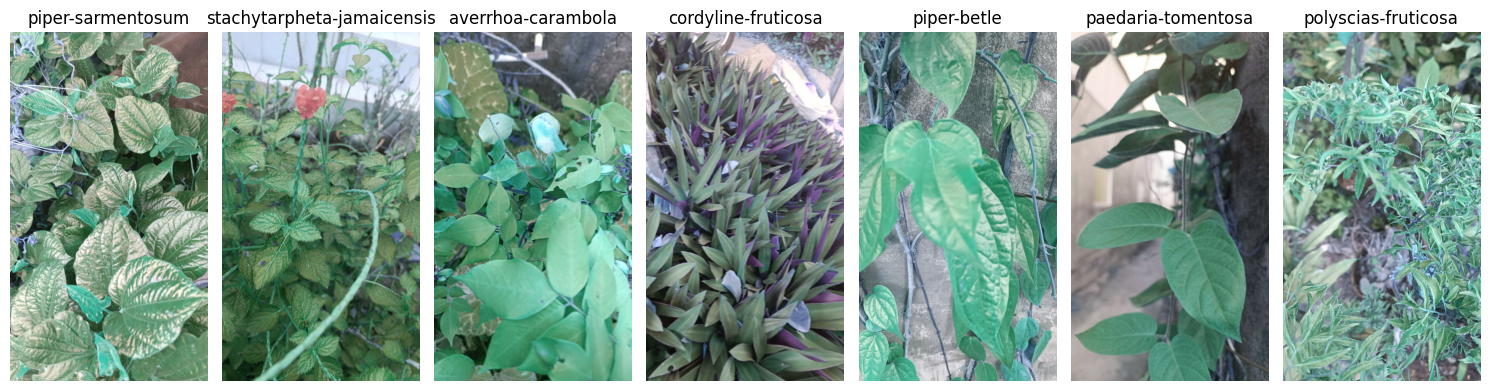

In [3]:
def insertGambar(folder):
    data = []
    datalabel = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder)):
            img_path = os.path.join(label_folder, filename)
            img = plt.imread(img_path)
            if img is not None:
                data.append(img)
                datalabel.append(label)
    return data, datalabel

data, label = insertGambar("dataset")
print("Data: ", len(data))
print("Label: ", len(label))
plot_one_image_per_label(data, label)


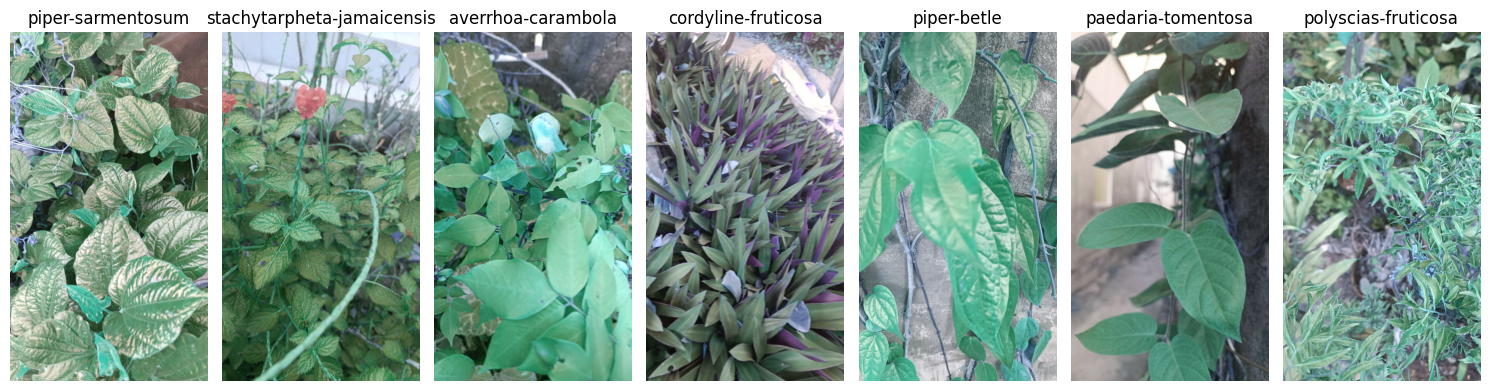

In [4]:
plot_one_image_per_label(data, label)

### Tahap 3: Data Preparation dan Augmentation

In [5]:
def resizeImage(data, ukuran):
    resizeData = []
    for img in data:
        resized_img = cv.resize(img, (ukuran, ukuran))
        resizeData.append(resized_img)
    return resizeData

In [6]:
def rotasi(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

In [7]:
def pencerminan(image, axis):
    return cv.flip(image, axis)

In [8]:
def augmentasi(data, labels, banyakData):
    augmented_data = []
    augmented_labels = []
    
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        
        for j in range(banyakData):
            if j % 4 == 0:
                rotated_90 = rotasi(data[i], 90)
                augmented_data.append(rotated_90)
                augmented_labels.append(labels[i])  
            elif j % 4 == 1:
                rotated_minus_90 = rotasi(data[i], -90)
                augmented_data.append(rotated_minus_90)
                augmented_labels.append(labels[i])
            elif j % 4 == 2:
                flipped_axis_0 = pencerminan(data[i], 0)
                augmented_data.append(flipped_axis_0)
                augmented_labels.append(labels[i])
            elif j % 4 == 3:
                flipped_axis_1 = pencerminan(data[i], 1)
                augmented_data.append(flipped_axis_1)
                augmented_labels.append(labels[i])
    augmented_filenames = []
    for idx, label in enumerate(augmented_labels):
        augmented_filenames.append(f"{label}_augmented_{idx}")
    
    return augmented_data, augmented_filenames, augmented_labels

In [9]:
dataResize = resizeImage(data, 300)
augmented_data, augmented_filenames, augmented_labels = augmentasi(dataResize, label, 4)

100%|██████████| 710/710 [00:02<00:00, 255.29it/s]


In [10]:
print("Jumlah total dataset setelah augmentasi:", len(augmented_data))

Jumlah total dataset setelah augmentasi: 3550


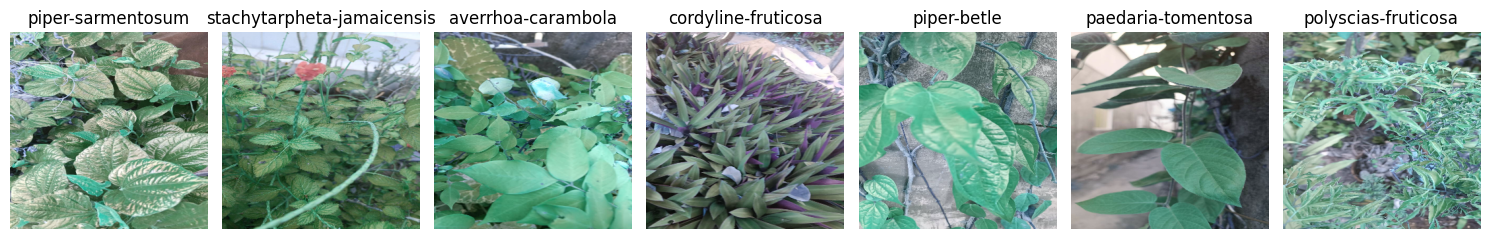

In [11]:
plot_one_image_per_label(augmented_data, augmented_labels)

### Tahap 4: Preprocessing

In [12]:
def grayscale(data):
    dataGray = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        dataGray.append(gray)
    return dataGray

In [13]:
def histogram_equalization(data):
    equalizedData = []
    for img in data:
        equalized_img = cv.equalizeHist(img)
        equalizedData.append(equalized_img)
    return equalizedData

In [14]:
def threshold(data):
    thresholdData = []
    for img in data:
        _, threshed_img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
        thresholdData.append(threshed_img)
    return thresholdData

In [15]:
def edge_detection(data):
    edgeData = []
    for img in data:
        edges = cv.Canny(img, 100, 200)
        edgeData.append(edges)
    return edgeData

In [16]:
def contour_detection(data):
    contourData = []
    for img in data:
        contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour_img = np.zeros_like(img)
        cv.drawContours(contour_img, contours, -1, (255, 255, 255), 1)
        contourData.append(contour_img)
    return contourData

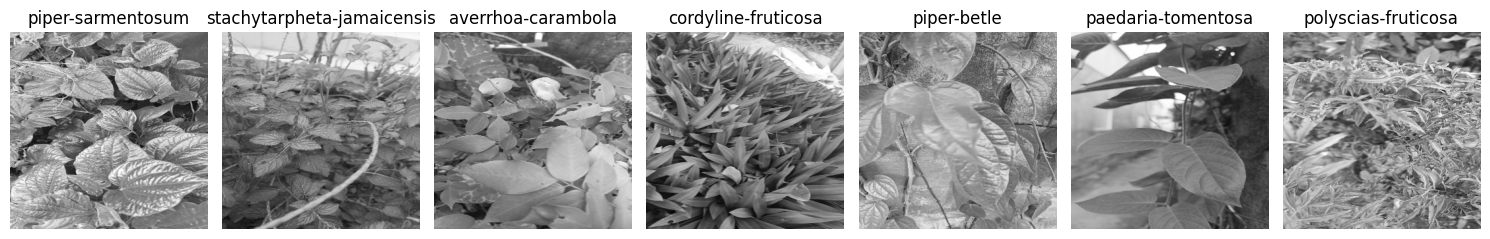

In [17]:
dataGray = grayscale(augmented_data)
plot_one_image_per_label(dataGray, augmented_labels)

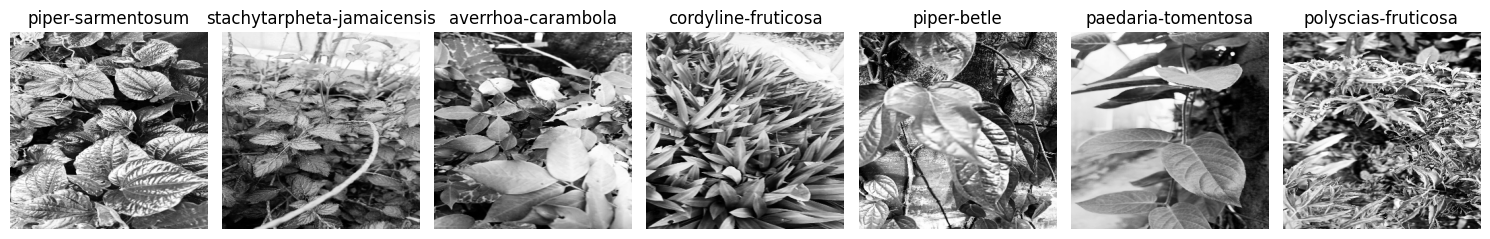

In [18]:
dataEqualized = histogram_equalization(dataGray)
plot_one_image_per_label(dataEqualized, augmented_labels)

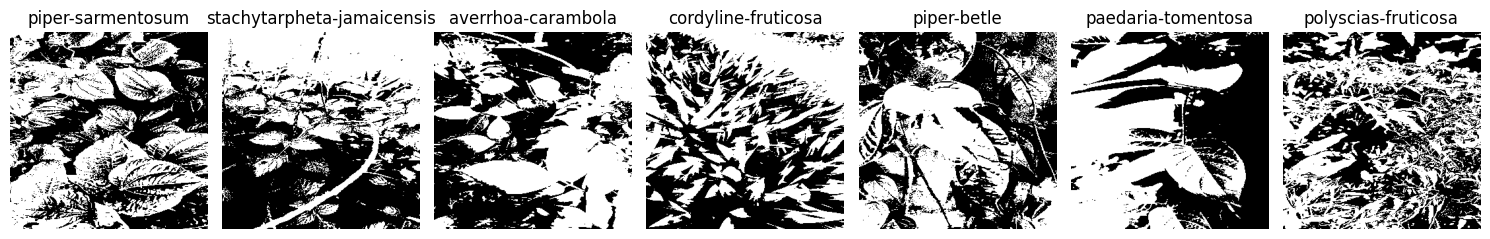

In [19]:
dataThreshold = threshold(dataEqualized)
plot_one_image_per_label(dataThreshold, augmented_labels)

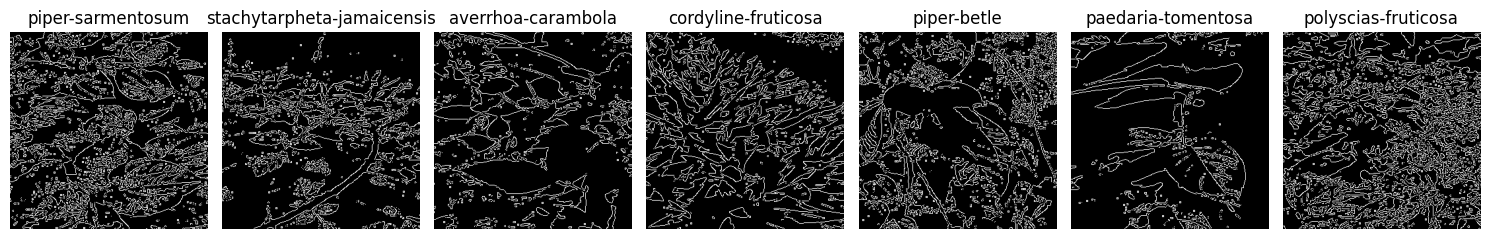

In [20]:
dataEdges = edge_detection(dataThreshold)
plot_one_image_per_label(dataEdges, augmented_labels)

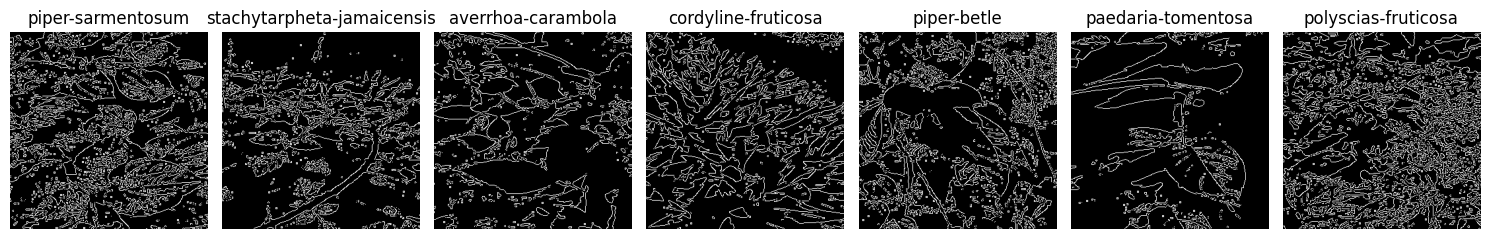

In [21]:
dataContours = contour_detection(dataEdges)
plot_one_image_per_label(dataContours, augmented_labels)

### Tahap 5: Model Building 

CNN

In [22]:
X_cnn = np.array(dataContours)
y_cnn = np.array(augmented_labels)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_cnn_encoded = encoder.fit_transform(y_cnn)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42)

X_cnn_train = X_cnn_train / 255.0
X_cnn_test = X_cnn_test / 255.0

In [23]:
# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_cnn_encoded)), activation='softmax')
])

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train CNN model
cnn_history = cnn_model.fit(X_cnn_train, y_cnn_train, epochs=10, validation_data=(X_cnn_test, y_cnn_test))

# Evaluasi model CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn_test, y_cnn_test)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1574 - loss: 3.0923 - val_accuracy: 0.2085 - val_loss: 1.8736
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.2729 - loss: 1.8256 - val_accuracy: 0.3690 - val_loss: 1.6982
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5316 - loss: 1.3064 - val_accuracy: 0.4014 - val_loss: 1.6272
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7324 - loss: 0.8086 - val_accuracy: 0.4099 - val_loss: 1.7340
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8278 - loss: 0.4983 - val_accuracy: 0.4268 - val_loss: 2.0736
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8615 - loss: 0.3836 - val_accuracy: 0.4099 - val_loss: 2.0431
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8967 - loss: 0.3022 - val_accuracy: 0.4127 - val_loss: 2.5094
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9107 - loss: 0.2544 - val_accuracy: 0.4169 - v

In [26]:
# Predict the labels on the test set
y_cnn_pred = cnn_model.predict(X_cnn_test)
y_cnn_pred_classes = np.argmax(y_cnn_pred, axis=1)

print("Accuracy CNN:", cnn_accuracy)
print(classification_report(y_cnn_test, y_cnn_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step
Accuracy CNN: 0.412676066160202
              precision    recall  f1-score   support

           0       0.42      0.35      0.38       134
           1       0.44      0.51      0.48       125
           2       0.29      0.37      0.32       104
           3       0.31      0.24      0.27        93
           4       0.38      0.23      0.29        65
           5       0.85      0.72      0.78        98
           6       0.28      0.40      0.33        91

    accuracy                           0.41       710
   macro avg       0.42      0.40      0.41       710
weighted avg       0.43      0.41      0.41       710



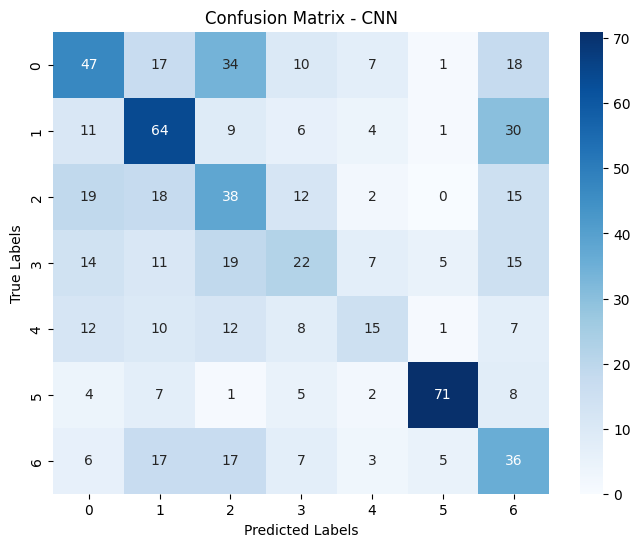

In [27]:
# Compute confusion matrix
conf_matrix_cnn = confusion_matrix(y_cnn_test, y_cnn_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()

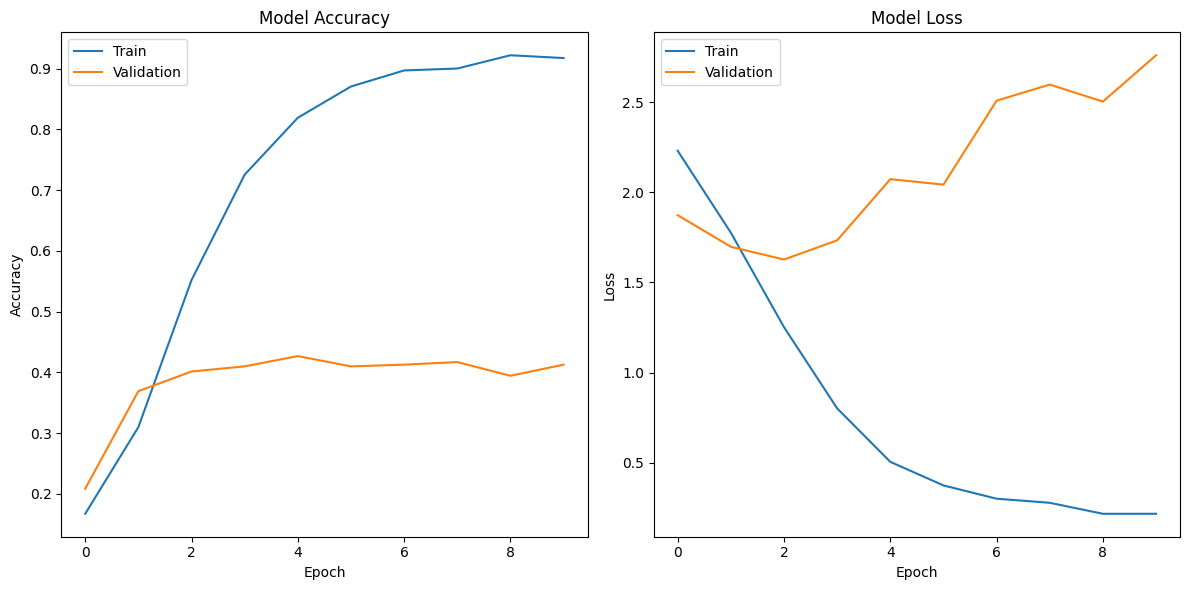

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()